# NTE Derivation in 1D for Tensor Trains
$$
\newcommand{\bo}{\boldsymbol{\hat{\Omega}}}
\newcommand{\x}{\boldsymbol{x}}
\newcommand{\o}{\Omega}
\newcommand{\p}{\partial}
\newcommand{\bm}{\boldsymbol}
\newcommand{\bx}{\boxed}
\newcommand{\f}{\frac}
\def\:#1\:{\begin{align}#1\end{align}}
\def\(#1\){\begin{\pmatrix}#1\end{pmatrix}}
\def\[#1\]{\begin{\bmatrix}#1\end{bmatrix}}
\def\s#1{\Sigma_{#1}}
\def\m#1{\mathcal{#1}}
$$

The 1D discretized NTE using discrete ordinates approximation for the angular dependence is (according to NERS 561 notes):
$$
\:
\f{\mu_n}{\Delta x_i}&[\psi_{i + 1/2, n, g} - \psi_{i - 1/2, n, g}] + \s{t, i, g}\psi_{i, n, g} \
&= \sum_{g' = 1}^G\sum_{l = 0}^{L}(2l + 1)P_l(\mu_n)\s{sl, g'\rightarrow g}\phi_{l, i, g'} + \f{\chi_g}{k}\sum_{g' = 1}^{G}\nu\s{f, i, g'}\phi_{0, i, g'},
\:
$$
where $i\in\{0, 1, ..., I - 1\}$ is the cell index in a cell-centered scheme, $n\in\{0, 1, ..., N - 1\}$ is the ordinate index, $g\in\{1, 2, ..., G\}$ is the group index, and $l\in\{0, 1, ..., L\}$ is the Legendre polynomial order. The $l$th Legendre moment of the angular flux is
$$
\phi_{l, i, g}(x) = \int_{-1}^1P_l(\mu)\psi_{i, g}(\mu)d\mu \approx \sum_{n = 0}^{N - 1}w_nP_l(\mu_n)\psi_{i, g}(\mu_n) = \sum_{n = 0}^{N - 1}w_nP_l(\mu_n)\psi_{i, n, g},
$$
where
$$
\sum_{n = 0}^{N - 1}w_n = 1
$$

Scalar flux is defined as
$$
\phi_{i, g} = \phi_{0, i, g} \approx \sum_{n = 0}^{N - 1}w_n\psi_{i, n, g}.
$$
We approximate the scattering behavior as isotropic such that
$$
\sum_{l = 0}^{L}(2l + 1)P_l(\mu_n)\s{sl, g'\rightarrow g}\phi_{l, i, g'} \rightarrow\s{s0, g'\rightarrow g}\sum_{n = 0}^{N - 1}w_n\psi_{i, n, g'}
$$

The NTE then becomes
$$
\:
\f{\mu_n}{\Delta x_i}&[\psi_{i + 1/2, n, g} - \psi_{i - 1/2, n, g}] + \s{t, i, g}\psi_{i, n, g} \\
&= \sum_{g' = 1}^G\s{s0, g'\rightarrow g}\sum_{n = 0}^{N - 1}w_n\psi_{i, n, g'} + \f{\chi_g}{k}\sum_{g' = 1}^{G}\nu\s{f, i, g'}\sum_{n = 0}^{N - 1}w_n\psi_{i, n, g},
\:
$$
We can close the system with diamond difference,
$$
\psi_{i, n, g} = \f{1}{2}(\psi_{i + 1/2, n, g} + \psi_{i - 1/2, n, g}).
$$
Plugging this in we get
$$
\:
\f{\mu_n}{\Delta x_i}&[\psi_{i + 1/2, n, g} - \psi_{i - 1/2, n, g}] + \f{1}{2}\s{t, i, g}(\psi_{i + 1/2, n, g} + \psi_{i - 1/2, n, g}) \\
=&~ \f{1}{2}\sum_{g' = 1}^G\s{s0, g'\rightarrow g}\sum_{n = 0}^{N - 1}w_n(\psi_{i + 1/2, n, g'} + \psi_{i - 1/2, n, g'}) \\
&+ \f{\chi_g}{2k}\sum_{g' = 1}^{G}\nu\s{f, i, g'}\sum_{n = 0}^{N - 1}w_n(\psi_{i + 1/2, n, g'} + \psi_{i - 1/2, n, g'}).
\:
$$

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True

from tt_nte.benchmarks import pu_brick, pu_brick_multi_region
from tt_nte.methods import DiscreteOrdinates
from tt_nte import solvers

import supporting.plotting as tt_plt

## Pu-239 from the [Criticality Verification Benchmark Suite](https://www.sciencedirect.com/science/article/pii/S0149197002000987/pdf?md5=299011580a5d17bc208703ef425a6ba6&pid=1-s2.0-S0149197002000987-main.pdf)

This problem includes a 1D brick of Pu-239 of width $3.707444~cm$ with one group of the following cross section information:

| $\s{t}~[cm^{-1}]$ | $\nu\s{f}~[cm^{-1}]$ | $\s{s}~[{cm^{-1}}]$ | $\chi_{1\rightarrow1}$ |
| :----------------- | :-------------------- | :------------------- | :---------------------- |
| 0.32640           | 0.264384             | 0.225216            | 1.0                    |

Below is the full matrix equation for $N=2$ and $I = 3$ with vacuum boundary conditions. The width of each cell is then $\Delta x = 3.707444~cm / I = 1.235815~cm$. 

The operators based on the NTE provided above are given below.

Streaming operator ($\bm H_x$):

| $\bm{H}_x$        | $\psi_{-1/2, 0}$       | $\psi_{1/2, 0}$        | $\psi_{3/2, 0}$        | $\psi_{5/2, 0}$       | $\psi_{-1/2, 1}$       | $\psi_{1/2, 1}$        | $\psi_{3/2, 1}$        | $\psi_{5/2, 1}$        |
| :----------------- | :---------------------- | :---------------------- | :---------------------- | :--------------------- | :---------------------- | :---------------------- | :---------------------- | :---------------------- |
| $\psi_{-1/2, 0}'$ | $\f{\mu_0}{\Delta x}$  |                        |                        |                       |                        |                        |                        |                        |
| $\psi_{1/2, 0}'$  | $-\f{\mu_0}{\Delta x}$ | $\f{\mu_0}{\Delta x}$  |                        |                       |                        |                        |                        |                        |
| $\psi_{3/2, 0}'$  |                        | $-\f{\mu_0}{\Delta x}$ | $\f{\mu_0}{\Delta x}$  |                       |                        |                        |                        |                        |
| $\psi_{5/2, 0}'$  |                        |                        | $-\f{\mu_0}{\Delta x}$ | $\f{\mu_0}{\Delta x}$ |                        |                        |                        |                        |
| $\psi_{-1/2, 1}'$ |                        |                        |                        |                       | -$\f{\mu_1}{\Delta x}$ | $\f{\mu_1}{\Delta x}$  |                        |                        |
| $\psi_{1/2, 1}'$  |                        |                        |                        |                       |                        | -$\f{\mu_1}{\Delta x}$ | $\f{\mu_1}{\Delta x}$  |                        |
| $\psi_{3/2, 1}'$  |                        |                        |                        |                       |                        |                        | -$\f{\mu_1}{\Delta x}$ | $\f{\mu_1}{\Delta x}$  |
| $\psi_{5/2, 1}'$  |                        |                        |                        |                       |                        |                        |                        | -$\f{\mu_1}{\Delta x}$ |

Total interaction operator ($\bm H_\Sigma$):

| $\bm{H}_\Sigma$   | $\psi_{-1/2, 0}$ | $\psi_{1/2, 0}$ | $\psi_{3/2, 0}$ | $\psi_{5/2, 0}$ | $\psi_{-1/2, 1}$ | $\psi_{1/2, 1}$ | $\psi_{3/2, 1}$ | $\psi_{5/2, 1}$ |
| ----------------- | ---------------- | --------------- | --------------- | --------------- | ---------------- | --------------- | --------------- | --------------- |
| $\psi_{-1/2, 0}'$ | $\s{t}/2$        |                 |                 |                 |                  |                 |                 |                 |
| $\psi_{1/2, 0}'$  | $\s{t}/2$        | $\s{t}/2$       |                 |                 |                  |                 |                 |                 |
| $\psi_{3/2, 0}'$  |                  | $\s{t}/2$       | $\s{t}/2$       |                 |                  |                 |                 |                 |
| $\psi_{5/2, 0}'$  |                  |                 | $\s{t}/2$       | $\s{t}/2$       |                  |                 |                 |                 |
| $\psi_{-1/2, 1}'$ |                  |                 |                 |                 | $\s{t}/2$        | $\s{t}/2$       |                 |                 |
| $\psi_{1/2, 1}'$  |                  |                 |                 |                 |                  | $\s{t}/2$       | $\s{t}/2$       |                 |
| $\psi_{3/2, 1}'$  |                  |                 |                 |                 |                  |                 | $\s{t}/2$       | $\s{t}/2$       |
| $\psi_{5/2, 1}'$  |                  |                 |                 |                 |                  |                 |                 | $\s{t}/2$       |

Scattering operator ($\bm S$):

| $\bm{S}$          | $\psi_{-1/2, 0}$ | $\psi_{1/2, 0}$ | $\psi_{3/2, 0}$ | $\psi_{5/2, 0}$ | $\psi_{-1/2, 1}$ | $\psi_{1/2, 1}$ | $\psi_{3/2, 1}$ | $\psi_{5/2, 1}$ |
| ----------------- | ---------------- | --------------- | --------------- | --------------- | ---------------- | --------------- | --------------- | --------------- |
| $\psi_{-1/2, 0}'$ |                  |                 |                 |                 |                  |                 |                 |                 |
| $\psi_{1/2, 0}'$  | $\s{s}w_0/2$     | $\s{s}w_0/2$    |                 |                 | $\s{s}w_1/2$     | $\s{s}w_1/2$    |                 |                 |
| $\psi_{3/2, 0}'$  |                  | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                 |                  | $\s{s}w_1/2$    | $\s{s}w_1/2$    |                 |
| $\psi_{5/2, 0}'$  |                  |                 | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                  |                 | $\s{s}w_1/2$    | $\s{s}w_1/2$    |
| $\psi_{-1/2, 1}'$ | $\s{s}w_0/2$     | $\s{s}w_0/2$    |                 |                 | $\s{s}w_1/2$     | $\s{s}w_1/2$    |                 |                 |
| $\psi_{1/2, 1}'$  |                  | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                 |                  | $\s{s}w_1/2$    | $\s{s}w_1/2$    |                 |
| $\psi_{3/2, 1}'$  |                  |                 | $\s{s}w_0/2$    | $\s{s}w_0/2$    |                  |                 | $\s{s}w_1/2$    | $\s{s}w_1/2$    |
| $\psi_{5/2, 1}'$  |                  |                 |                 |                 |                  |                 |                 |                 |

Fission operator ($\bm F$):

| $\bm{F}$          | $\psi_{-1/2, 0}$ | $\psi_{1/2, 0}$ | $\psi_{3/2, 0}$ | $\psi_{5/2, 0}$ | $\psi_{-1/2, 1}$ | $\psi_{1/2, 1}$ | $\psi_{3/2, 1}$ | $\psi_{5/2, 1}$ |
| ----------------- | ---------------- | --------------- | --------------- | --------------- | ---------------- | --------------- | --------------- | --------------- |
| $\psi_{-1/2, 0}'$ |                  |                 |                 |                 |                  |                 |                 |                 |
| $\psi_{1/2, 0}'$  | $\nu\s{f}w_0/2$  | $\nu\s{f}w_0/2$ |                 |                 | $\nu\s{f}w_1/2$  | $\nu\s{f}w_1/2$ |                 |                 |
| $\psi_{3/2, 0}'$  |                  | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                 |                  | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |                 |
| $\psi_{5/2, 0}'$  |                  |                 | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                  |                 | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |
| $\psi_{-1/2, 1}'$ | $\nu\s{f}w_0/2$  | $\nu\s{f}w_0/2$ |                 |                 | $\nu\s{f}w_1/2$  | $\nu\s{f}w_1/2$ |                 |                 |
| $\psi_{1/2, 1}'$  |                  | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                 |                  | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |                 |
| $\psi_{3/2, 1}'$  |                  |                 | $\nu\s{f}w_0/2$ | $\nu\s{f}w_0/2$ |                  |                 | $\nu\s{f}w_1/2$ | $\nu\s{f}w_1/2$ |
| $\psi_{5/2, 1}'$  |                  |                 |                 |                 |                  |                 |                 |                 |

These operators are then used to construct the eigenvalue problem
$$
[\bm H_x + \bm H_{\Sigma}]\Psi = \f{1}{k}\bm F \Psi.
$$
For a Gauss-Legendre quadrature set of $N = 2$: $\mu_0 = 0.5774$ and $\mu_1 = -0.5774$. The weights of these ordinates are $w_0 = w_1 = 0.5$. We can verify the $S_N$ solver in `discrete_ordinates.py` is building the tensors/matrices correctly.

### Discrete Ordinates Solver Implementation

The $S_N$ solver in `discrete_ordinates.py` builds the $d$-way operators based on the tensor cores provided in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520). The tensor trains for $\mu_n > 0$ in 1D are
$$
\:
\bm {\m H}_x^{TT, 1} &= \bm I_G \circ \bm Q_{\mu} \circ \bm{D}_x^+,\\
\bm {\m H}_\Sigma^{TT, 1} &= \text{diag}(\Sigma_t)\circ(\bm{C}_1\otimes\bm{I}_{L/2})\circ \bm {Ip}_x^+,\\
\bm {\m F}^{TT, 1} &= \bm{\Sigma}_f \circ \bm{Intg}^1\circ\bm{Ip}_{x, noBC}^+,\\
\bm{\m S}^{TT, 1} &=  \bm{\Sigma}_s \circ \bm{Intg}^1\circ\bm{Ip}_{x, noBC}^+,
\:
$$
where all definitions are consistent with [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520); however, the definitions related to directions were reduced from 8 octants to 2 halfspaces. Additionally, the definition of the integral operator as defined in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520) is incorrect. The integral operator is
$$
\bm{Intg}^1 = \bm A_1 \otimes (\bm 1_{L/2}\otimes w),
$$
where $\bm A_1$ is 
$$
\bm A_1 = \begin{pmatrix}
1 & 1\\
0 & 0
\end{pmatrix}.
$$
In general, $(\bm A_i)_{i:} = 1$ and zeros everywhere else for $i \in \{0, ..., 7\}$ in the case of 3D and $i \in \{0,1\}$ for 1D.

The `TensorTrain.matricize()` method computes the tensor dots and Kronecker products to build the full $G\times N\times (I + 1)\times G\times N\times (I + 1)$ tensor operators and flattens it into a $GN(I + 1)\times GN(I + 1)$ matrix. It then converts these from `numpy.ndarray`s to `scipy.sparse.csc_matrix`s since all operators are ~99% sparse. It then computes the inverse of $\bm{H} =\bm{H}_x + \bm{H}_{\Sigma}$, $\bm{H}^{-1}$, and applies that to the right-hand side of the matrix form NTE during power iteration.

We can compare the resulting operators to those defined in the prior section to verify this solver.

In [2]:
# Get problem XSs and geometry
xs_server, geometry = pu_brick(4)

# Initialize SN solver
SN = DiscreteOrdinates(
    xs_server=xs_server, geometry=geometry, num_ordinates=2,
)

print("Streaming + Total Interaction Operator")
pd.DataFrame(SN.H.matricize().todense())

Streaming + Total Interaction Operator


,0,1,2,3,4,5,6,7
0,0.630382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.303982,0.630382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.303982,0.630382,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,-0.303982,0.630382,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.630382,-0.303982,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.630382,-0.303982,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630382,-0.303982
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630382


In [3]:
print("Scattering Operator")
pd.DataFrame(SN.S.matricize().todense())

Scattering Operator


,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000
2,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000
3,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304
4,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000
5,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304,0.000000
6,0.000000,0.000000,0.056304,0.056304,0.000000,0.000000,0.056304,0.056304
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
print("Fission Operator")
pd.DataFrame(SN.F.matricize().todense())

Fission Operator


,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000
2,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000
3,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096
4,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000
5,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096,0.000000
6,0.000000,0.000000,0.066096,0.066096,0.000000,0.000000,0.066096,0.066096
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


All three operators match the operator matrices derived above.

To solve this system, we can use any of the following solvers within `tt_nte.solvers`:

- `Matrix`: supports both a generalized eigenvalue solver (GES) and a power iteration solver in Compressed Sparse Column (CSC) format,
- `ALS`: supports both a GES and a power iteration solver using Alternating Linear Scheme (ALS) to solve for $\m{\psi}^{(i + 1)}$ in $\m{H}\m{\psi}^{(i + 1)} = (\m{S} + \f{1}{k^{(i)}}\m{F})\m{\psi}^{(i)}$ for iteration $i$ in the TT/QTT format,
- `MALS`: supports a power iteration solver using Modified ALS (MALS) to solve for $\m{\psi}^{(i + 1)}$ in the TT/QTT format,
- `AMEn`: supports a power iteration solver using the Alternating Minimal Energy Method to solve for $\m{\psi}^{(i + 1)}$ in the TT/QTT format,
- `GMRES`: supports a power iteration solver using GMRES to solve for $\m{\psi}^{(i + 1)}$ in the TT/QTT format.

Below shows an example of using ALS to solve the above system.

-- ALS Power Iteration
--   Iteration = 10, k = 0.7841, psi error = 0.00014867376532637385
-- Converged: k = 0.78417663


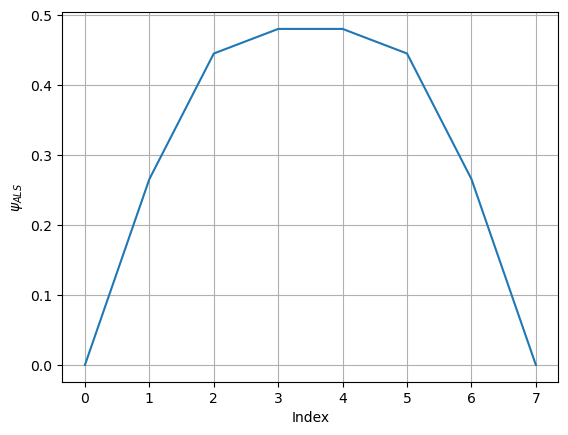

In [5]:
solver = solvers.ALS(method=SN, verbose=True)
solver.power(ranks=4, tol=1e-6, max_iter=100)

plt.clf()
plt.plot(solver.psi.matricize())
plt.xlabel(xlabel="Index")
plt.ylabel(ylabel="$\psi_{ALS}$")
plt.show()

As another example, we can use AMEn and find both solvers produce similar results.

-- AMEn Power Iteration
amen_solve: swp=1, max_dx= 7.233E-01, max_res= 8.749E-01, max_rank=2
amen_solve: swp=2, max_dx= 0.000E+00, max_res= 9.080E-16, max_rank=2
amen_solve: swp=1, max_dx= 1.753E-01, max_res= 1.739E-01, max_rank=2
amen_solve: swp=2, max_dx= 0.000E+00, max_res= 2.607E-16, max_rank=2
amen_solve: swp=1, max_dx= 6.625E-02, max_res= 6.628E-02, max_rank=2
amen_solve: swp=2, max_dx= 0.000E+00, max_res= 4.908E-16, max_rank=2
amen_solve: swp=1, max_dx= 2.585E-02, max_res= 2.586E-02, max_rank=2
amen_solve: swp=2, max_dx= 0.000E+00, max_res= 3.842E-16, max_rank=2
amen_solve: swp=1, max_dx= 1.024E-02, max_res= 1.025E-02, max_rank=2
amen_solve: swp=2, max_dx= 0.000E+00, max_res= 4.308E-16, max_rank=2
amen_solve: swp=1, max_dx= 4.085E-03, max_res= 4.086E-03, max_rank=2
amen_solve: swp=2, max_dx= 0.000E+00, max_res= 4.460E-16, max_rank=2
amen_solve: swp=1, max_dx= 1.633E-03, max_res= 1.633E-03, max_rank=2
amen_solve: swp=2, max_dx= 0.000E+00, max_res= 4.107E-16, max_rank=2
amen_solve

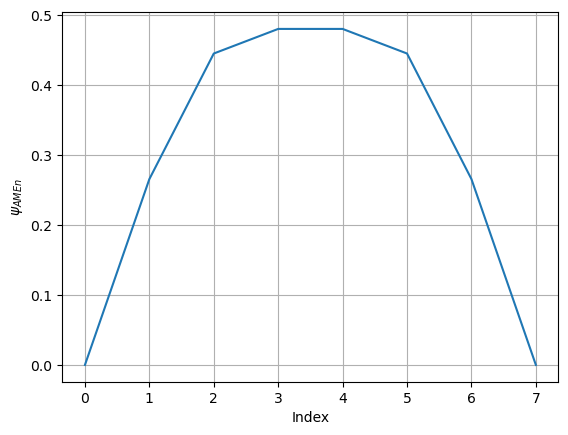

In [6]:
solver = solvers.AMEn(method=SN, verbose=True)
solver.power(tol=1e-6, max_iter=100)

plt.clf()
plt.plot(solver.psi.matricize())
plt.xlabel(xlabel="Index")
plt.ylabel(ylabel="$\psi_{AMEn}$")
plt.show()

### TT Paper Reproduction

Below is a reproduction of the results presented in [Truong et al.](https://www.sciencedirect.com/science/article/pii/S002199912400192X#br0520) with additional solvers. We include the following solvers:

- Mat/GES: generalized eigenvalue solver in CSC format using `scipy.sparse.linalg.eigs()`,
- Mat/Power: power iteration in CSC format using `scipy.sparse.linalg.inv()`,
- TT-ALS: power iteration using ALS in TT format,
- QTT-ALS: power iteration using ALS in QTT format,
- QTT-MALS: power iteration using MALS in QTT format,
- QTT-AMEn: power iteration using the AMEn in QTT format,
- QTT-GMRES: power iteration using GMRES in QTT format.

-- Mat/GES
--   N = 2, k = 0.80418, exec_time = 0.007
--   N = 4, k = 0.94714, exec_time = 0.01
--   N = 8, k = 0.99176, exec_time = 0.022
--   N = 16, k = 0.99847, exec_time = 0.152
--   N = 32, k = 0.99964, exec_time = 0.905
-- Mat/Power
--   N = 2, k = 0.80418, exec_time = 0.276
--   N = 4, k = 0.94714, exec_time = 0.702
--   N = 8, k = 0.99176, exec_time = 1.982
--   N = 16, k = 0.99847, exec_time = 6.294
--   N = 32, k = 0.99964, exec_time = 22.176
-- TT-ALS
--   N = 2, k = 0.80418, exec_time = 1.685
--   N = 4, k = 0.94714, exec_time = 9.369
--   N = 8, k = 0.99174, exec_time = 10.416
--   N = 16, k = 0.99829, exec_time = 9.601
--   N = 32, k = 0.99943, exec_time = 10.504
-- QTT-ALS
--   N = 2, k = 0.80418, exec_time = 0.125
--   N = 4, k = 0.94714, exec_time = 0.159
--   N = 8, k = 0.99174, exec_time = 0.169
--   N = 16, k = 0.99818, exec_time = 0.173
--   N = 32, k = 0.99903, exec_time = 0.202
-- QTT-MALS
--   N = 2, k = 0.80418, exec_time = 0.121
--   N = 4, k = 0.94714, exec_

<Figure size 640x480 with 0 Axes>

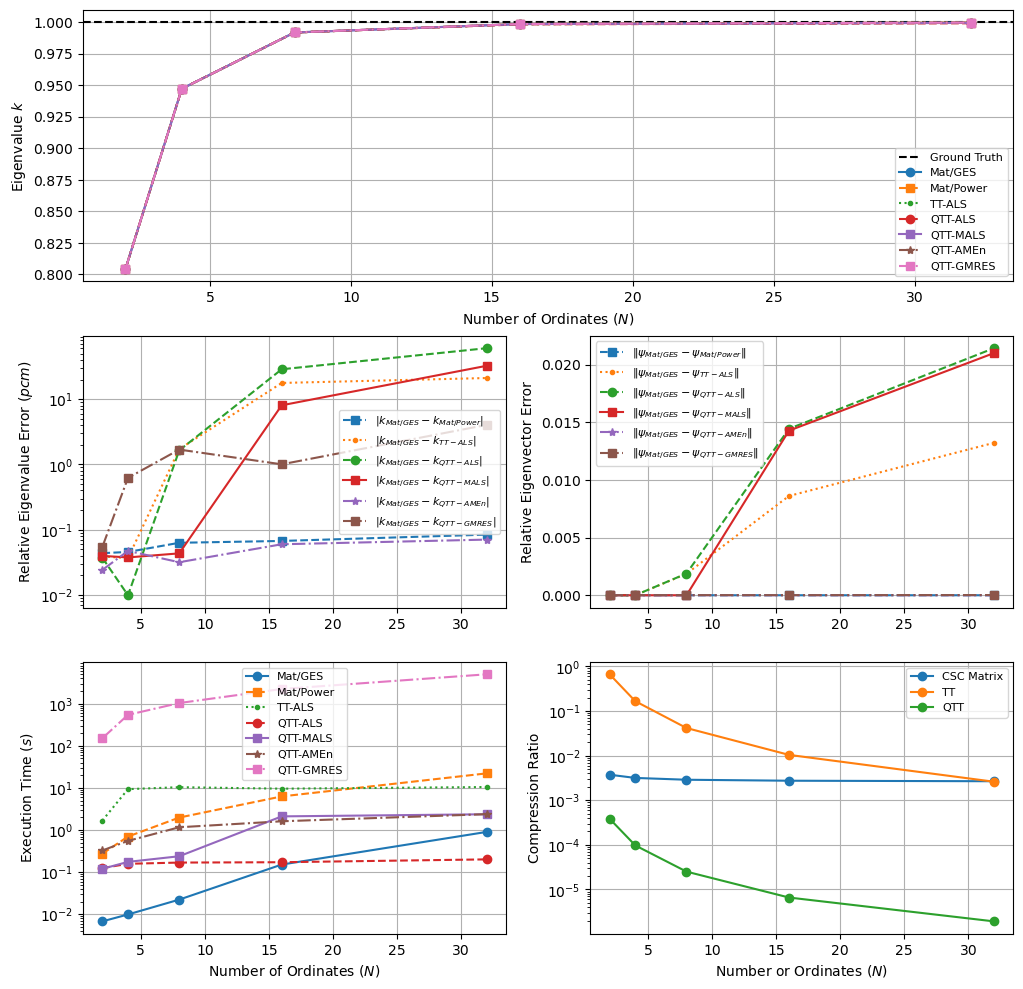

In [7]:
# Increase slab geometry fidelity
xs_server, geometry = pu_brick(1024)

SN.update_settings(xs_server=xs_server, geometry=geometry)

tt_solvers = {
    "Mat/Power": (solvers.Matrix, {"tt_fmt": "tt"}, {}, {}, "s--"),
    "TT-ALS": (solvers.ALS, {"tt_fmt": "tt"}, {}, {"ranks": 4}, ".:"),
    "QTT-ALS": (
        solvers.ALS, 
        {"tt_fmt": "qtt", "qtt_threshold": 1e-15}, 
        {},
        {"ranks": 4},
        "o--",
    ),
    "QTT-MALS": (
        solvers.MALS, 
        {"tt_fmt": "qtt", "qtt_threshold": 1e-15}, 
        {"max_rank": 20}, 
        {"ranks": 4}, 
        "s-"
    ),
    "QTT-AMEn": (
        solvers.AMEn, 
        {"tt_fmt": "qtt", "qtt_threshold": 1e-15}, 
        {}, 
        {},
        "*-."
    ),
    "QTT-GMRES": (
        solvers.GMRES, 
        {"tt_fmt": "qtt", "qtt_threshold": 1e-15}, 
        {}, 
        {}, 
        "s-."
    ),
}

num_ordinates = 2 ** np.arange(1, 6)

plt.clf()
fig = plt.figure(figsize=(12, 12))
tt_plt.plot_ordinate_perturbation(SN, num_ordinates, tt_solvers, fig=fig)
plt.show()

### Accuracy Dependence on Solution Rank

The execution and accuracy of the solution using ALS in TT/QTT format depends on the rank of the initial guess, as the ranks of the cores in the solution do not change during the iterations. This is remedied in MALS, AMEn, and GMRES.

-- Rank = 2, k = 0.99299, exec_time = 2.745 s
-- Rank = 4, k = 0.99943, exec_time = 10.273 s
-- Rank = 8, k = 0.99964, exec_time = 30.903 s
-- Rank = 16, k = 0.99964, exec_time = 100.685 s
-- Rank = 32, k = 0.99964, exec_time = 615.697 s


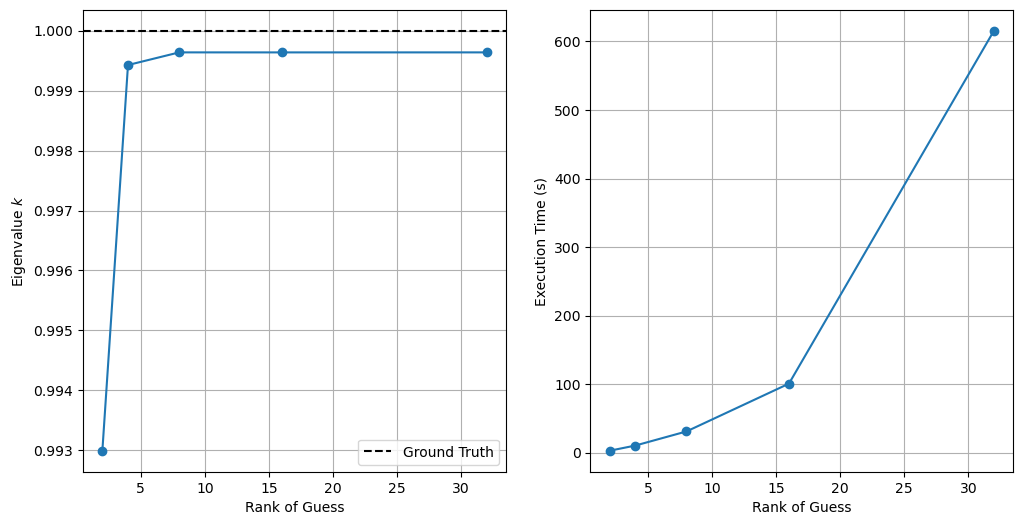

In [8]:
ranks = np.array(2 ** np.arange(1, 6), dtype=int)

ks = []
exec_times = []

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
axs[0].axhline(1.0, color="k", ls="--", label="Ground Truth")

for rank in ranks:
    print(f"-- Rank = {rank},", end=" ")
    
    # Update solver
    SN.update_settings(num_ordinates=32, tt_fmt="tt")
    
    # Run and time solver
    solver = solvers.ALS(method=SN)
    
    start = time.time()
    solver.power(ranks=rank, max_iter=1000)
    stop = time.time()
    
    ks.append(solver.k)
    exec_times.append(stop - start)
        
    print(f"k = {np.round(ks[-1], 5)}, exec_time = {np.round(exec_times[-1], 3)} s")

axs[0].plot(np.array(ranks, dtype=int), ks, "-o")
axs[1].plot(np.array(ranks, dtype=int), exec_times, "-o")

axs[0].set(xlabel="Rank of Guess", ylabel="Eigenvalue $k$")
axs[1].set(xlabel="Rank of Guess", ylabel="Execution Time (s)")

axs[0].legend()

plt.show()

### Effect of Region Splitting on QTT SVD

To introduce heterogeneity into these methods, we treat each unique region as a separate TT with a mask applied to their spatial cores corresponding to the regions they represent. These are then summed to produce the operators of the NTE and the total system. Below are plots of the singular values for the cores of each operator in QTT format using 1 region (left) and 4 regions (right) to represent the plutonium brick. Core 0 corresponds to the angular core and Core 1 is the spatial core. Some cores in both the angular and spatial dimensions elongate, indicating higher ranks include more information about the system; however, a majority of the information is still in those first few ranks.

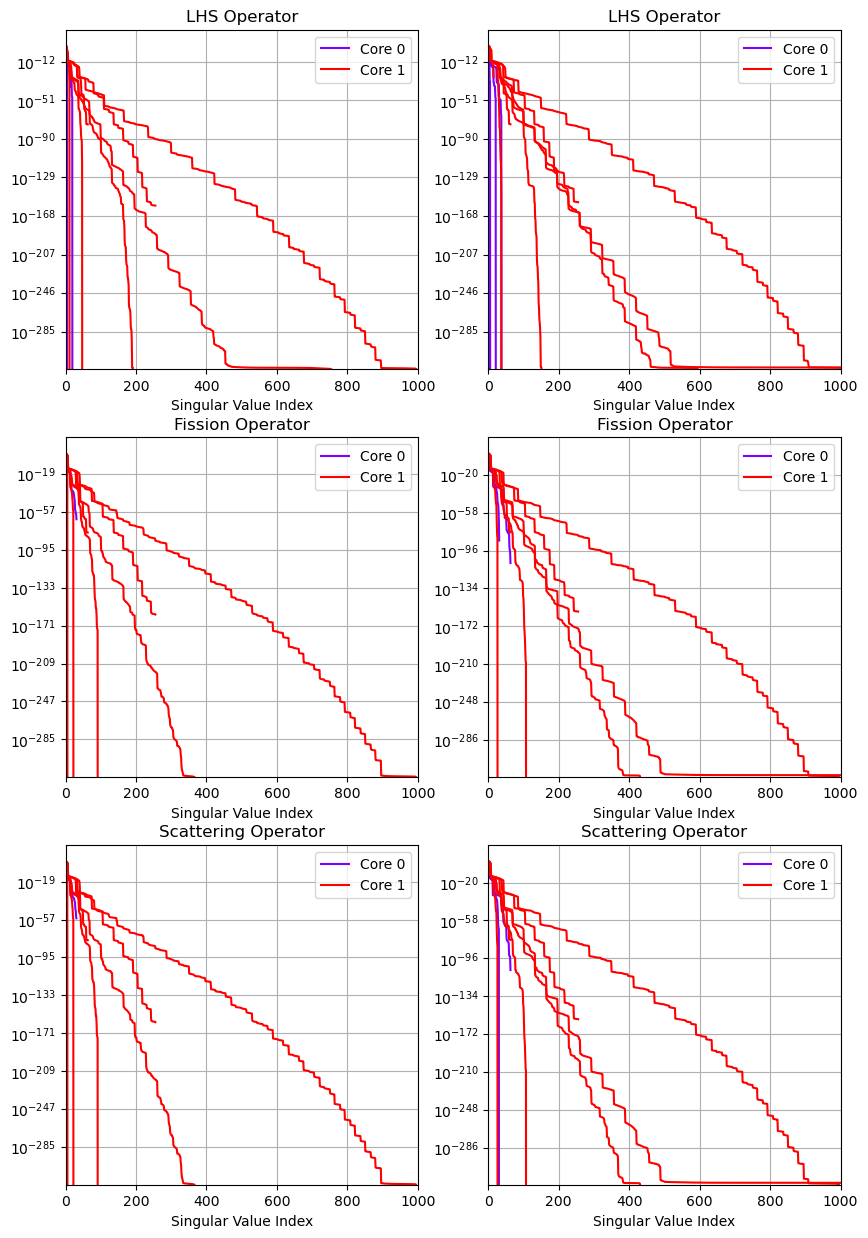

In [9]:
# Get problem-specific XSs and geometry
xs_server, geometry = pu_brick_multi_region(1024, 1)

# Initialize SN solver
SN = DiscreteOrdinates(
    xs_server=xs_server, 
    geometry=geometry, 
    num_ordinates=32, 
    tt_fmt="tt",
)

_, axs = plt.subplots(3, 2, figsize=(10, 15))
tt_plt.plot_qtt_svd(SN, axs=axs[:, 0])

# Increase problem to 4 regions
xs_server, geometry = pu_brick_multi_region(1024, 4)
SN.update_settings(xs_server=xs_server, geometry=geometry)
tt_plt.plot_qtt_svd(SN, axs=axs[:, 1])

plt.setp(axs, xlim=[0, 1000])
plt.show()

#### Sum of Core Ranks in TT/QTT Format

To demonstrate the dependence of the cores' ranks on the number of spatial regions, we plot the sum of the cores' ranks for each operator versus the number of regions below. In the TT format, the sum linearly increases; in the QTT format, there is more fluctuation depending on the number of regions. In the case the number of regions is a power of 2 we observe the lowest number of ranks in the QTT operators. The next lowest number of ranks is when the number of regions is even. Finally, the highest number of ranks occurs when the number of regions is odd.

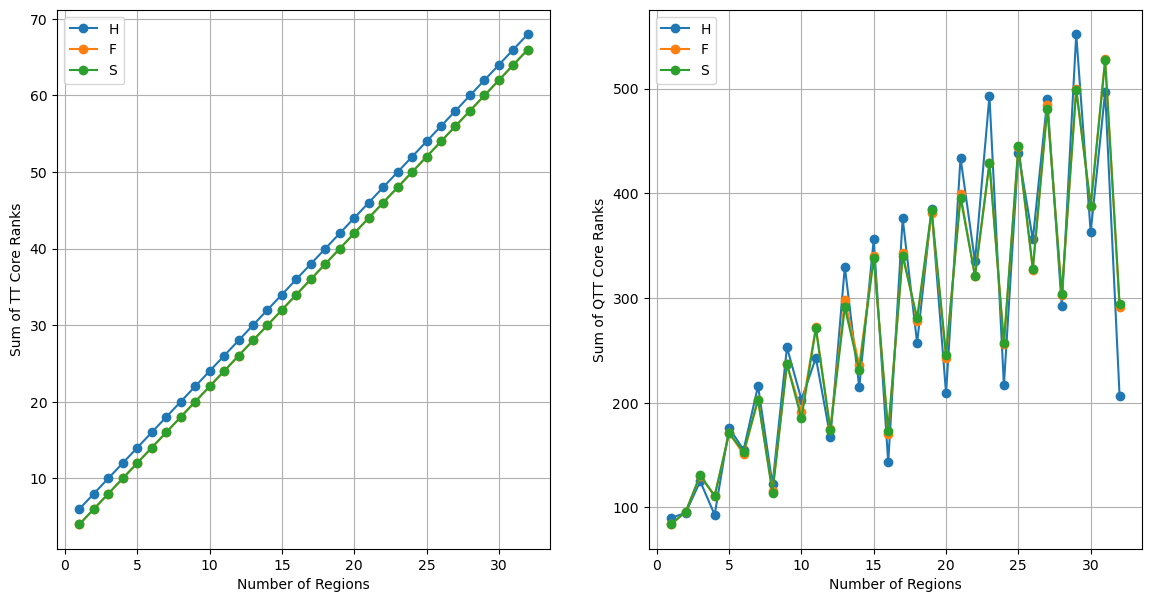

In [10]:
num_regions_list = np.arange(1, 33)

tt_ranks = {"H": [], "F": [], "S": []}
qtt_ranks = {"H": [], "F": [], "S": []}

for num_regions in num_regions_list:
    xs_server, geometry = pu_brick_multi_region(1024, num_regions)

    SN.update_settings(xs_server=xs_server, geometry=geometry)
    tt_ranks["H"].append(np.sum(SN.H.ranks))
    tt_ranks["F"].append(np.sum(SN.F.ranks))
    tt_ranks["S"].append(np.sum(SN.S.ranks))

    # Convert to QTT
    SN.H.tt2qtt()
    SN.F.tt2qtt()
    SN.S.tt2qtt()
    
    qtt_ranks["H"].append(np.sum(SN.H.ranks))
    qtt_ranks["F"].append(np.sum(SN.F.ranks))
    qtt_ranks["S"].append(np.sum(SN.S.ranks))

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for name, ranks in tt_ranks.items():
    axs[0].plot(num_regions_list, ranks, "o-", label=name)
axs[0].set(xlabel="Number of Regions", ylabel="Sum of TT Core Ranks")
axs[0].legend()

for name, ranks in qtt_ranks.items():
    axs[1].plot(num_regions_list, ranks, "o-", label=name)
axs[1].set(xlabel="Number of Regions", ylabel="Sum of QTT Core Ranks")
axs[1].legend()

plt.show()